# Lab 1: Uncertainty Quantification for OOD detection

Prepared by Nikita Kotelevskii

# Types of Uncertainty

![Sources of uncertainty](./helpers/pics/epistemic_vs_aleatoric.png)

## Aleatoric uncertainty

Aleatoric uncertainty is that part of predictive uncertainty that is associated with inherent noise or inherent randomness. A characteristic feature of this uncertainty is that it cannot be reduced by adding more data.


Examples of inherent randomness in data are the prediction of a random outcome -- for example, a coin toss.

In the context of machine learning, aleatoric uncertainty can be further divided into two categories:

1. **Homoscedastic uncertainty:** This type of aleatoric uncertainty remains constant at various points in the input data. This usually happens when the noise in the data is relatively uniform across different inputs. For example, when measuring the height of individuals, the measurement error is likely to be fairly constant, which will lead to homoscedastic uncertainty.

2. **Heteroskedastic uncertainty:** This type of aleatoric uncertainty varies depending on the input data. This usually happens when the noise in the data changes depending on the input data. For example, in the task of forecasting housing prices, the level of uncertainty may be higher for luxury homes (due to fewer sales and greater price variability) compared to medium-cost homes.

Understanding and accounting for aleatoric uncertainty is essential in many machine learning tasks for making reliable predictions and decisions. Methods such as MaxProb and others are used to quantify this uncertainty and include it in the output of machine learning models.

## Epistemic uncertainty

Epistemic uncertainty arises from a lack of knowledge. Unlike aleatoric uncertainty, which is inherent in data, epistemic uncertainty can potentially be reduced by collecting more data, improving our models, or collecting more information about the problem at hand.

Epistemic uncertainty usually occurs when we have limited data from which our models learn. The uncertainty, in fact, arises from our lack of understanding or ignorance of the entire distribution of data.

For example, in the context of machine learning:

1. If we train the model on a small data set, the model can work well with training data, but poorly with data that it has not seen, which illustrates the high epistemic uncertainty. By collecting more training data, we can potentially reduce this uncertainty.

2. If we use a simplified model (for example, linear regression) for a problem where the true relationship is complex and nonlinear, the predictions of the model will have high epistemic uncertainty. Using a more complex model (for example, a deep neural network), we can potentially better capture complexity and reduce this uncertainty.

## Installation of necessary software

In [1]:
!git clone https://github.com/nkotelevskii/helpers.git
!git clone https://github.com/wjmaddox/swa_gaussian.git

fatal: destination path 'helpers' already exists and is not an empty directory.
fatal: destination path 'swa_gaussian' already exists and is not an empty directory.


In [2]:
!pip3 install torch torchvision torchaudio
!pip3 install gpytorch
!pip3 install -U scikit-learn
!pip3 install tqdm
!pip3 install matplotlib

# How will the lab be organized?

- In this notebook, we will see how different methods will work with the task of OOD (out-of-distribution) detection.
- We will have pre-trained models on CIFAR-100 (InD -- in-distribution).
- There will be OOD datasets. I chose two. The first of them is CIFAR10. Although this dataset is very similar to CIFAR100, it has other, disjoint classes. However, this is a "close" OOD precisely because of the similarity of the images. The second one is SVHN (images of numbers on houses). This is a "distant" OOD, since the data looks completely different.

- Let's try different methods for OOD detection
- At the end, let's compare them all in the summary table.

### Necessary preparations

In [3]:
### Import everything we need
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, './helpers')

from reliability_diagrams import reliability_diagram
from temperature_scaling import ModelWithTemperature
from preresnet import PreResNet20, PreResNet20Spectral
from preresnet_dropout import PreResNet20Drop

from aux import (
    plot_histogram_eq_width,
    plot_images,
    collect_labels_and_probs,
    load_ensembles,
    collect_labels_and_probs_ensemble,
    compute_scores_ensemble,
    ensemble_calibration,
    collect_labels_and_probs_mcdropout,
    compute_scores_mcdropout
)

In [4]:
# Fix all the seeds

def seed_everything(seed: int) -> None:
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [5]:
# This is the list where we will write results for all the methods. In the end of the notebook we will compare them on a table/
RESULTS = []

In [6]:
# Fix a device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preparing the data

In [7]:
# We have 20 pretrained models
# Let's fix one of them to see, how well does one model do the job.

# Let it be a model with index of 0
MODEL_INDEX = 0

# We will use an architecture of PreResNet
model_conf = PreResNet20()
model = model_conf.base(*model_conf.args, num_classes=100, **model_conf.kwargs)
model.load_state_dict(torch.load(f'./helpers/ensembles/preresnet20-{MODEL_INDEX}.pth', map_location=device))
model = model.to(device)
model.eval()

# If everything was imported correctly, we will see OK!
print("OK!")

OK!


In [8]:
# Normalizing constants, used for training on CIFAR-100
# For all the other datasets (CIFAR-10 and SVHN) we will use the same normalization, as on the training!
MEAN_CIFAR100 = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
STD_CIFAR100 = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        MEAN_CIFAR100,
        STD_CIFAR100
        )
])

# Load CIFAR100 train
cifar100_train = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
# Load CIFAR100 val
cifar100_valid = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)


# Additionally, load OOD datasets
cifar10_valid = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

svhn_valid = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


In [9]:
# Since test part of SVHN is huge, we will load only 10000 random objects
indices = torch.randperm(len(svhn_valid))
indices = indices[:10000]

svhn_valid.data = svhn_valid.data[indices]
svhn_valid.labels = svhn_valid.labels[indices]

In [10]:
# As we will later calibrate predictions of the trained classifier on CIFAR100,
# we will split old validation data into new validation and calibration datasets

cal_proportion = 0.25
split_threshold = int(np.floor(cal_proportion * len(cifar100_valid)))

indices = torch.randperm(len(cifar100_valid))

calibration_idx, validation_idx = indices[:split_threshold], indices[split_threshold:]


cifar100_calib = deepcopy(cifar100_valid)
cifar100_calib.data = cifar100_calib.data[calibration_idx]
cifar100_calib.targets = np.array(cifar100_calib.targets)[calibration_idx].tolist()

cifar100_valid.data = cifar100_valid.data[validation_idx]
cifar100_valid.targets = np.array(cifar100_valid.targets)[validation_idx].tolist()

In [11]:
len(cifar100_calib), len(cifar100_valid)

(2500, 7500)

In [12]:
# Create dataloaders. 
batch_size = 500
cifar100_trainloader = torch.utils.data.DataLoader(cifar100_train, batch_size=10 * batch_size, shuffle=True)
cifar100_valloader = torch.utils.data.DataLoader(cifar100_valid, batch_size=batch_size, shuffle=False)
cifar100_calloader = torch.utils.data.DataLoader(cifar100_calib, batch_size=batch_size, shuffle=False)

cifar10_valloader = torch.utils.data.DataLoader(cifar10_valid, batch_size=batch_size, shuffle=False)
svhn_valloader = torch.utils.data.DataLoader(svhn_valid, batch_size=batch_size, shuffle=False)

### How will we evaluate the quality of OOD detection?

- One of the ways to evaluate the quality of OOD detection is as follows.
- We take data from the distribution of training data (for example, validation dataset)
- Also, we take OOD datasets.
- For all data, we make uncertainty predictions using some metrics. For example, using BALD (recall below).
- It turns out now for each object we have some number (a measure of uncertainty). And we also know whether this object is really OOD, or InD.
- Therefore, we can consider the OOD/InD binary classification problem. And for the uncertainty values, calculate the ROC AUC.
- The higher the ROC AUC, the better we separate InD and OOD data.

# Simple methods to quantify uncertainty

## Maximum Probability Method (MaxProb)

Let's say our model $f_{\theta}$ with parameters $\theta$ predicts parameters of a Categorical distribution: $\hat{p}(y \mid x, \theta) := \hat{p}(y \mid x, f_{\theta})$.

Lets try the following thing to measure the uncertainty:

$$
1 - \max_c \hat{p}(y=c \mid x, \theta)
$$


The Maximum Probability Method (MaxProb) is a simple approach to quantifying (**aleatoric**) uncertainty, which is inherent noise or randomness in data. It is mainly used in classification problems, where models produce a probability distribution over possible classes.


In MaxProb, the uncertainty of the model is estimated using the maximum output probability. A higher maximum probability corresponds to less uncertainty and a more confident forecast. Conversely, a lower maximum probability indicates a greater level of uncertainty.

**This method assumes that the probabilities produced by the model are well calibrated.** However, this does not provide an estimate of epistemological uncertainty, which is due to a lack of our knowledge and can potentially be reduced with more data or a more complex model.

## Entropy

But MaxProb has a disadvantage - it considers only one, the maximum probability.
A simple improvement to this metric would be to use prediction entropy.

It looks like this:
$$
\mathbb{H}p(y \mid x, \theta) = -\sum_{c=1}^C p(y=c \mid x, \theta) \log p(y=c \mid x, \theta).
$$

Here, in total, there are already probabilities of all classes. This means that we have more information about the entire predicted distribution.

Entropy is easy to understand from the point of view of physics. 

Entropy characterizes the measure of disorder. The more ordered the system is, the fewer states it can accept, the lower the entropy. On the contrary, if the system has many degrees of freedom and it is not ordered, then the entropy will be high.

![Entropy_1](./helpers/pics/entropy_vis_1.png)

In [13]:
# The function which will compute scores for the given model and dataset 
def compute_scores(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    device: torch.device | str
) -> tuple[np.ndarray, np.ndarray]:
    
    model.eval()
    entropy_scores = []
    maxprob_scores = []
    with torch.no_grad():
        for data in data_loader:
            images, _ = data
            images = images.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)

            np_probs = probabilities.cpu().numpy()
            
            #entropy_score = # YOUR CODE HERE
            #maxprob_score = # YOUR CODE HERE
            entropy_score = -np.sum(np_probs * np.log(np_probs), axis=-1)
            maxprob_score = 1 - np.max(np_probs, axis=-1)
            
            entropy_scores.extend(entropy_score.tolist())
            maxprob_scores.extend(maxprob_score.tolist())
            
    return entropy_scores, maxprob_scores

In [14]:
# Compute scores for CIFAR100
cifar100_entropy_scores, cifar100_maxprob_scores = compute_scores(model, cifar100_valloader, device)

# Compute scores for CIFAR10
cifar10_entropy_scores, cifar10_maxprob_scores = compute_scores(model, cifar10_valloader, device)

# Compute scores for SVHN
svhn_entropy_scores, svhn_maxprob_scores = compute_scores(model, svhn_valloader, device)

### Visualization of the metrics

Let's understand whether we have done the job well or badly with the task of separating OOD and InD.

For a qualitative assessment, we will use visualization. Let's build histograms of the resulting scores.

If the separation is obvious on the histograms, then we coped with the task well.

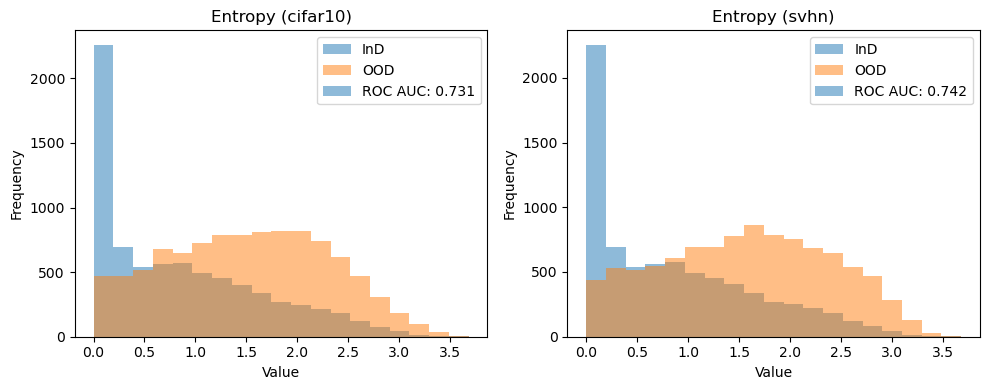

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_entropy_single = plot_histogram_eq_width(axs[0], data1=cifar100_entropy_scores, data2=cifar10_entropy_scores, title="Entropy (cifar10)")
roc_auc_svhn_entropy_single = plot_histogram_eq_width(axs[1], data1=cifar100_entropy_scores, data2=svhn_entropy_scores, title="Entropy (svhn)")

plt.tight_layout()
plt.show()

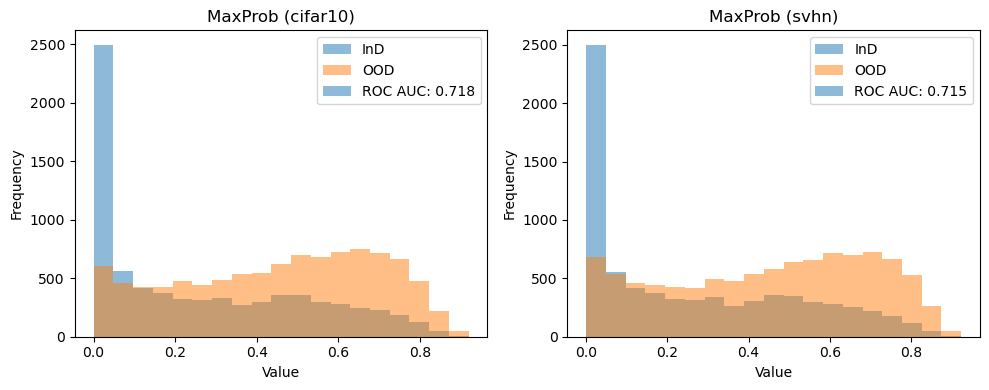

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_maxprob_single = plot_histogram_eq_width(axs[0], data1=cifar100_maxprob_scores, data2=cifar10_maxprob_scores, title="MaxProb (cifar10)")
roc_auc_svhn_maxprob_single = plot_histogram_eq_width(axs[1], data1=cifar100_maxprob_scores, data2=svhn_maxprob_scores, title="MaxProb (svhn)")

plt.tight_layout()
plt.show()

## Let's look at the objects.

Since CIFAR10 and CIFAR100 are very similar, it will be difficult for us, looking at the objects, to understand from which dataset this object came.

Therefore, I suggest looking at CIFAR100 vs SVHN.

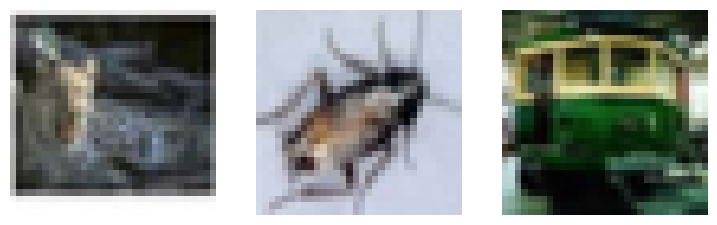

In [17]:
plot_images(dataset=cifar100_valid, indices=np.array([1, 2, 3]))

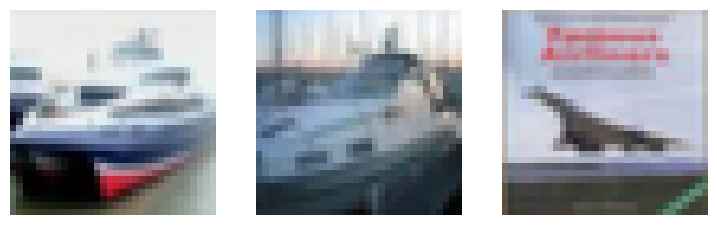

In [18]:
plot_images(dataset=cifar10_valid, indices=np.array([1, 2, 3]))

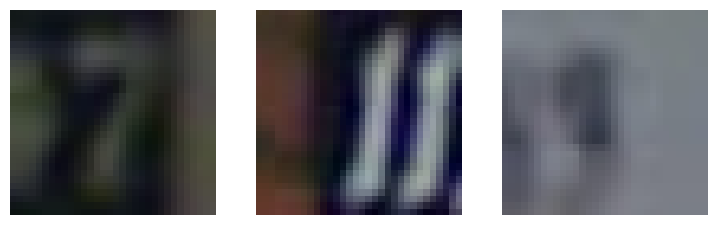

In [19]:
plot_images(dataset=svhn_valid, indices=np.array([1, 2, 3]))

### Find the top most confident/unconfident objects

In [20]:
def get_extreme_score_indices(scores0: list, scores1: list, k: int, extreme='max'):

    all_scores = np.concatenate((scores0, scores1))

    indices = np.argsort(all_scores)

    if extreme == 'max':
        idxs = indices[-k:]
    elif extreme == 'min':
        idxs = indices[:k]
    else:
        raise ValueError("`extreme` must be either 'min' or 'max'")

    dataset_idxs = (idxs >= len(scores0)) * 1
    within_dataset_idxs = np.where(dataset_idxs == 0, idxs, idxs - len(scores0))

    return dataset_idxs, within_dataset_idxs

#### Entropy

In [21]:
dataset_idxs, within_dataset_idxs = get_extreme_score_indices(
    scores0=cifar100_entropy_scores,
    scores1=svhn_entropy_scores,
    k=10, extreme='max'
)

In [22]:
# Which share of OOD objects appeared in top k the most uncertain?
np.mean(dataset_idxs)

0.5

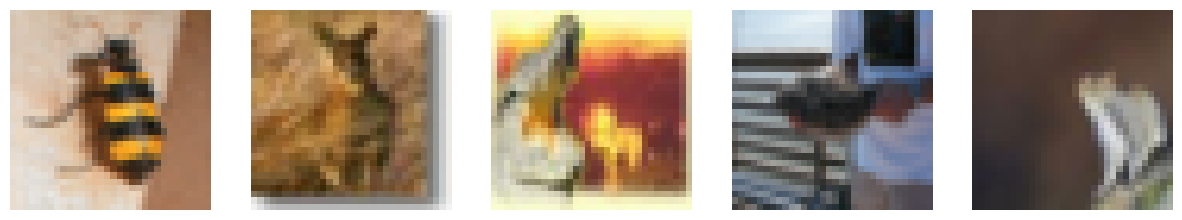

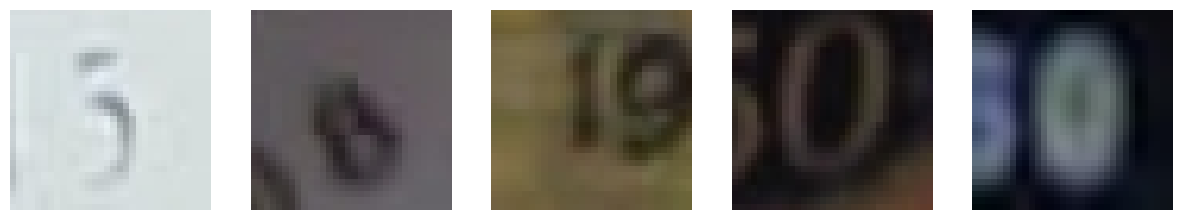

In [23]:
plot_images(dataset=cifar100_valid, indices=within_dataset_idxs[dataset_idxs==0])
plot_images(dataset=svhn_valid, indices=within_dataset_idxs[dataset_idxs==1])

#### MaxProb

In [24]:
dataset_idxs, within_dataset_idxs = get_extreme_score_indices(
    scores0=cifar100_maxprob_scores,
    scores1=svhn_maxprob_scores,
    k=10, extreme='max'
)

In [25]:
# Which share of OOD objects appeared in top k the most uncertain?
np.mean(dataset_idxs)

1.0

<Figure size 0x300 with 0 Axes>

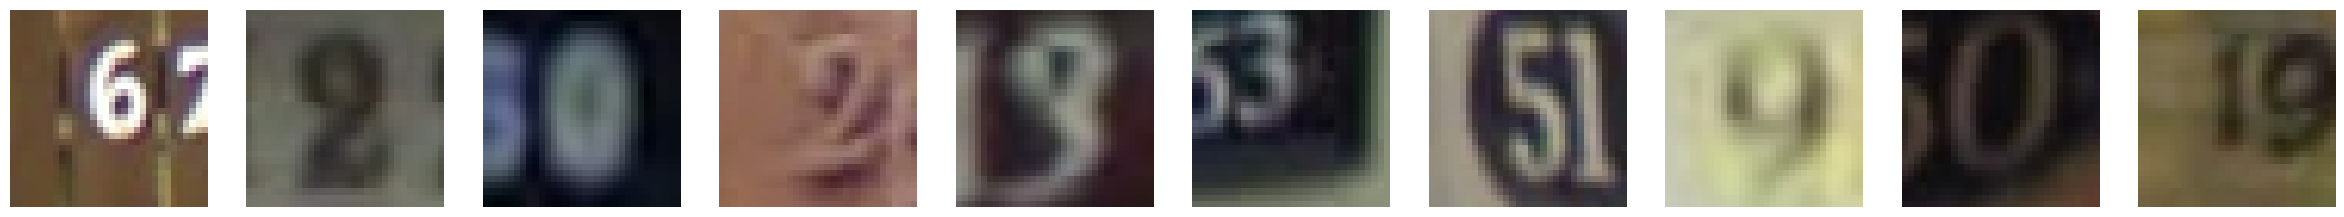

In [26]:
plot_images(dataset=cifar100_valid, indices=within_dataset_idxs[dataset_idxs==0])
plot_images(dataset=svhn_valid, indices=within_dataset_idxs[dataset_idxs==1])

### Saving the resulting scores

Let's add the ROC AUC results to the dictionary. At the end, we will build a summary table and see what works best.

In [27]:
RESULTS.append({
    "method": "single model",
    "ood": "cifar10",
    "entropy": roc_auc_cifar10_entropy_single,
    "maxprob": roc_auc_cifar10_maxprob_single
})

In [28]:
RESULTS.append({
    "method": "single model",
    "ood": "svhn",
    "entropy": roc_auc_svhn_entropy_single,
    "maxprob": roc_auc_svhn_maxprob_single
})

In [29]:
RESULTS

[{'method': 'single model',
  'ood': 'cifar10',
  'entropy': 0.731,
  'maxprob': 0.718},
 {'method': 'single model', 'ood': 'svhn', 'entropy': 0.742, 'maxprob': 0.715}]

# Calibration of the Neural Networks predictions

**On Calibration of Modern Neural Networks**

https://proceedings.mlr.press/v70/guo17a/guo17a.pdf

Calibration of neural network predictions is a process in which the values predicted by the model are adjusted so that they can be better interpreted as a probability. This is important because in many applications neural networks are required not only to predict the class, but also to indicate the level of confidence in their forecast.


We say that the model is calibrated if for all examples with predicted probabilities p, the true probability that these examples belong to the class that the model predicts is also p.


For example, if we have 100 examples for which the model predicts Class A with a probability of 0.8, then if the model is calibrated, about 80 of these examples will actually belong to Class A.

There are many calibration methods, but in this example we will consider the simplest one - temperature scaling.

The idea of the method is very simple: first we train the neural network (we do everything as usual), and then we freeze its parameters and add a new one. This new trainable parameter is temperature. Then, on the calibration set, we maximize the likelihood by updating only this temperature parameter.

To assess how well the model is calibrated, you can use a metric called `Expected Calibration Error (ECE)".

$$
\text{ECE} = \sum_{m=1}^{M} \frac{|B_m|}{n} \left| \text{acc}(B_m) - \text{conf}(B_m) \right|
$$


In [30]:
labels, probs = collect_labels_and_probs(model_=model, dataloader=cifar100_valloader, device=device)

In [31]:
accuracy_score(y_true=labels, y_pred=np.argmax(probs, axis=-1))

0.6844

### Reliabitity Diagrams

To visualize how well the model is calibrated, so-called Reliability Diagrams are used.

The idea is this - for each object from the validation sample, a vector of `probabilities" is predicted. The maximum ones are selected from them and sorted in ascending order.

Next, we split this sorted array into cells, and inside each we count accuracy.

/Users/maxim.panov/Work/courses/uncertainty_quantification_industrial/labs/lab1/./helpers/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


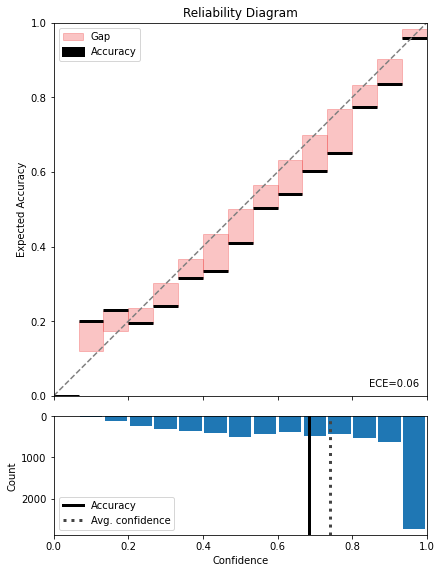

In [32]:
reliability_diagram(
    true_labels=labels,
    pred_labels=np.argmax(probs, axis=-1),
    confidences=probs[np.arange(len(probs)),
                      np.argmax(probs, axis=-1)
                      ],
     num_bins=15
    )

## Let's try to calibrate our model

Calibration of the model will be done using Temperature Scaling.

The advantages of this method are that it requires training only one parameter, and only one run through the dataset is enough to train it well.

In [33]:
calibrated_model = ModelWithTemperature(deepcopy(model))
calibrated_model.set_temperature(cifar100_calloader, device)
calibrated_model.eval()
print("OK!")

Before temperature - NLL: 1.189, ECE: 0.066
Optimal temperature: 1.280
After temperature - NLL: 1.147, ECE: 0.021
OK!


In [34]:
labels, calibrated_probs = collect_labels_and_probs(model_=calibrated_model, dataloader=cifar100_valloader, device=device)

#### Do you think accuracy will change after calibration?

In [35]:
accuracy_score(y_true=labels, y_pred=np.argmax(calibrated_probs, axis=-1))

0.6844

/Users/maxim.panov/Work/courses/uncertainty_quantification_industrial/labs/lab1/./helpers/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


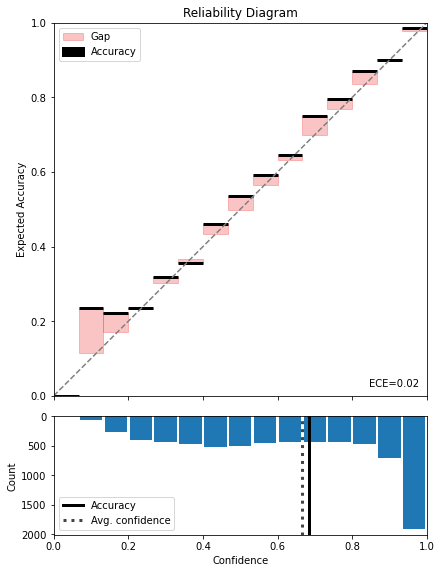

In [36]:
reliability_diagram(
    true_labels=labels,
    pred_labels=np.argmax(calibrated_probs, axis=-1),
    confidences=calibrated_probs[
        np.arange(len(calibrated_probs)),
        np.argmax(calibrated_probs, axis=-1)
                      ],
     num_bins=15
    )

In [37]:
# Compute scores for CIFAR100
cifar100_entropy_scores_cal, cifar100_maxprob_scores_cal = compute_scores(calibrated_model, cifar100_valloader, device)

# Compute scores for OOD datasets
cifar10_entropy_scores_cal, cifar10_maxprob_scores_cal = compute_scores(calibrated_model, cifar10_valloader, device)
svhn_entropy_scores_cal, svhn_maxprob_scores_cal = compute_scores(calibrated_model, svhn_valloader, device)

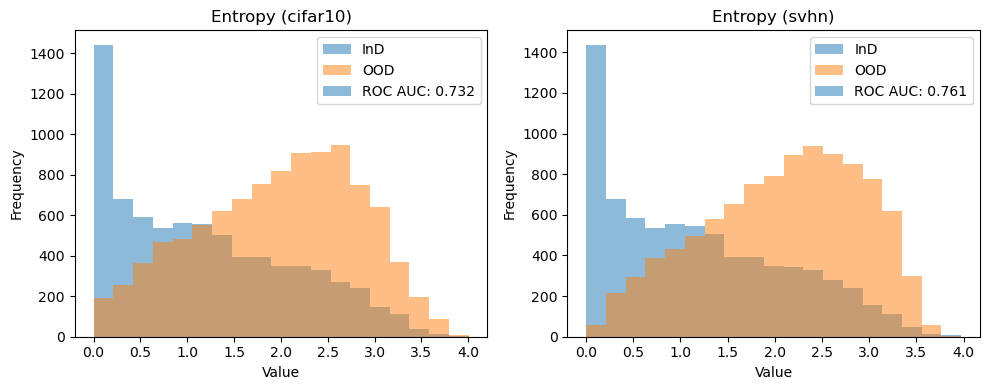

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_entropy_single_cal = plot_histogram_eq_width(axs[0], data1=cifar100_entropy_scores_cal, data2=cifar10_entropy_scores_cal, title="Entropy (cifar10)")
roc_auc_svhn_entropy_single_cal = plot_histogram_eq_width(axs[1], data1=cifar100_entropy_scores_cal, data2=svhn_entropy_scores_cal, title="Entropy (svhn)")

plt.tight_layout()
plt.show()

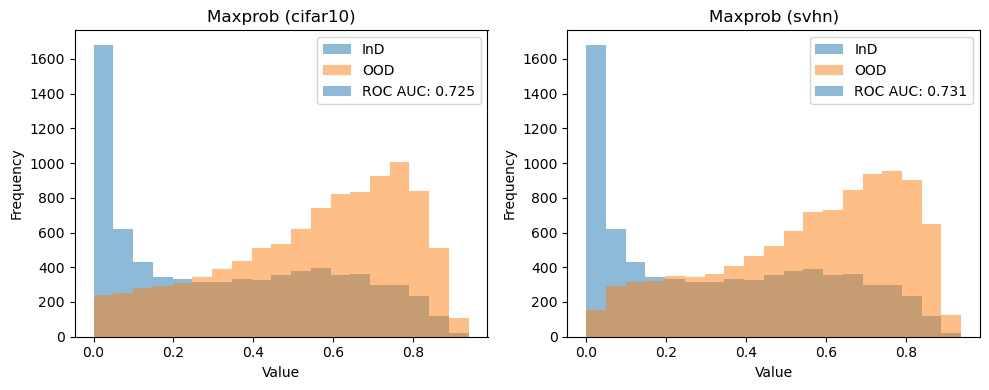

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_maxprob_single_cal = plot_histogram_eq_width(axs[0], data1=cifar100_maxprob_scores_cal, data2=cifar10_maxprob_scores_cal, title="Maxprob (cifar10)")
roc_auc_svhn_maxprob_single_cal = plot_histogram_eq_width(axs[1], data1=cifar100_maxprob_scores_cal, data2=svhn_maxprob_scores_cal, title="Maxprob (svhn)")

plt.tight_layout()
plt.show()

### Top of the most uncertain

#### Entropy

In [40]:
dataset_idxs, within_dataset_idxs = get_extreme_score_indices(
    scores0=cifar100_entropy_scores_cal,
    scores1=svhn_entropy_scores_cal,
    k=10, extreme='max'
)

In [41]:
# Which share of OOD objects appeared in top k the most uncertain?
np.mean(dataset_idxs)

0.3

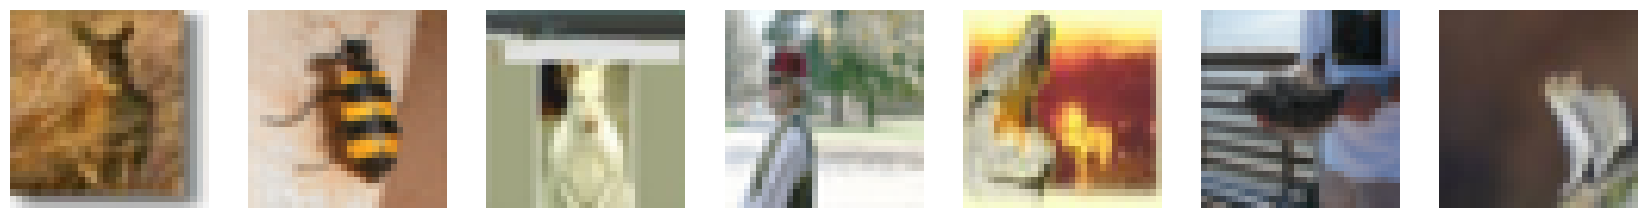

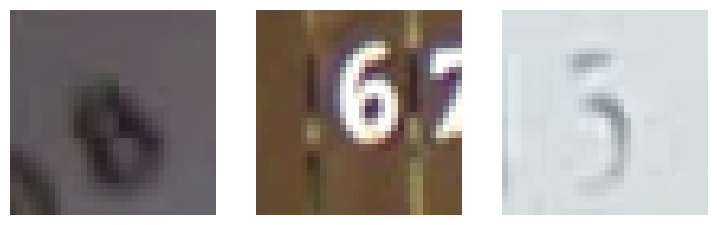

In [42]:
plot_images(dataset=cifar100_valid, indices=within_dataset_idxs[dataset_idxs==0])
plot_images(dataset=svhn_valid, indices=within_dataset_idxs[dataset_idxs==1])

#### MaxProb

In [43]:
dataset_idxs, within_dataset_idxs = get_extreme_score_indices(
    scores0=cifar100_maxprob_scores_cal,
    scores1=svhn_maxprob_scores_cal,
    k=10, extreme='max'
)

In [44]:
# Which share of OOD objects appeared in top k the most uncertain?
np.mean(dataset_idxs)

1.0

<Figure size 0x300 with 0 Axes>

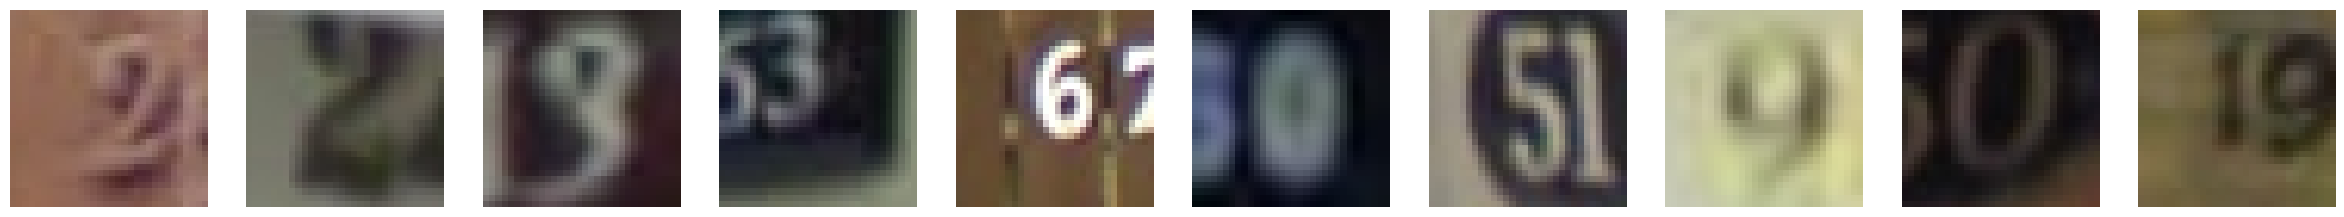

In [45]:
plot_images(dataset=cifar100_valid, indices=within_dataset_idxs[dataset_idxs==0])
plot_images(dataset=svhn_valid, indices=within_dataset_idxs[dataset_idxs==1])

### Questions:

Does calibration affect accuracy?

What is better -- overconfidence or underconfidence?

In [46]:
RESULTS.append({
    "method": "single model cal",
    "ood": "cifar10",
    "entropy": roc_auc_cifar10_entropy_single_cal,
    "maxprob": roc_auc_cifar10_maxprob_single_cal
})

In [47]:
RESULTS.append({
    "method": "single model cal",
    "ood": "svhn",
    "entropy": roc_auc_svhn_entropy_single_cal,
    "maxprob": roc_auc_svhn_maxprob_single_cal
})

# Deep emsembles

https://proceedings.neurips.cc/paper_files/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf

Lakshminarayanan B., Pritzel A., Blundell C. Simple and scalable predictive uncertainty estimation using deep ensembles //Advances in neural information processing systems. – 2017. – Vol. 30.


As we discussed in the lecture, the use of ensembles can be considered as a method of approximate Bayesian inference.


If we have a posterior distribution on the model parameters, $p(\theta\mid D_{\text{tr}})$, then the weights of the ensemble members can be considered as samples from this distribution.

Recall that usually the predictive posterior distribution is obtained like this:

$$
p(y \mid x, D_{\text{tr}}) = \int_{\theta} p(y \mid x, \theta)p(\theta \mid D_{\text{tr}}) d\theta,
$$

and this integral is very difficult to calculate in practice (or even impossible, except in special cases). Therefore, it is usually approximated using the so-called Monte Carlo estimate:

$$
p(y\mid x, D_{\text{tr}}) \approx\frac{1}{K}\sum_{k=1}^K p(y\mid x, \theta_k),
$$
where $\theta_k \sim p(\theta \mid D_{\text{tr}})$.

And this is exactly how predictions for ensembles are obtained in practice!

In [48]:
# Lets load pretrained ensembles
ensemble = load_ensembles(device=device)

In [49]:
# Question -- how many models in the ensemble do we have?

In [50]:
labels, ensemble_probs = collect_labels_and_probs_ensemble(ensemble_=ensemble, dataloader=cifar100_valloader, device=device)

In [51]:
# Lets try the accuracy of the ensemble
# It is way better than the accuracy of a single model!

accuracy_score(y_true=labels, y_pred=np.argmax(ensemble_probs, axis=-1))

0.7586666666666667

/Users/maxim.panov/Work/courses/uncertainty_quantification_industrial/labs/lab1/./helpers/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


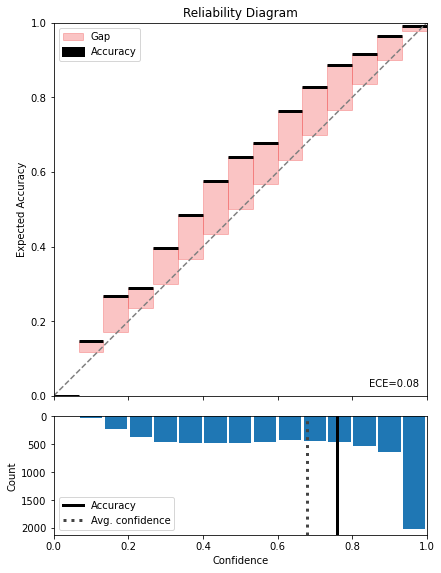

In [52]:
reliability_diagram(
    true_labels=labels,
    pred_labels=np.argmax(ensemble_probs, axis=-1),
    confidences=ensemble_probs[
        np.arange(len(ensemble_probs)),
        np.argmax(ensemble_probs, axis=-1)
                      ],
     num_bins=15
    )

One of the advantages of Bayesian methods is that we have the ability to get multiple samples of weights. This is crucial for the computation of uncertainty measures.

Indeed, having several different samples of weights (in other words, several models), we can somehow take into account their agreement/disagreement with each other, and put this into the uncertainty metrics.


For Bayesian (and similar) models, we will use the following metrics:

- $\mathcal{H}\mathbb{E} p(y \mid x, \theta) = \mathcal{H} p(y\mid x, D_{\text{tr}})$ -- entropy of the predicted posterior distribution. It contains **all the uncertainty.**

- $\mathbb{E} \mathcal{H} p(y \mid x, \theta)$ -- expected entropy. In fact, this is the **average aleatoric uncertainty** for the members of the ensemble.

- $\mathcal{H}\mathbb{E} p(y \mid x, \theta) - \mathbb{E} \mathcal{H} p(y \mid x, \theta)$ -- the difference between them. Since the first term is a complete uncertainty, and the second is only aleatoric, **the difference is a measure of epistemic uncertainty.** In the literature, this difference is called BALD.

![Uncertainty measures intuition](./helpers/pics/uq_measure_example_eng.jpg)

In [53]:
# Compute scores for CIFAR100
cifar100_EH_ensemble, cifar100_HE_ensemble, cifar100_maxprob_ensemble = compute_scores_ensemble(ensemble, cifar100_valloader, device)

# Compute scores for OOD
cifar10_EH_ensemble, cifar10_HE_ensemble, cifar10_maxprob_ensemble = compute_scores_ensemble(ensemble, cifar10_valloader, device)
svhn_EH_ensemble, svhn_HE_ensemble, svhn_maxprob_ensemble = compute_scores_ensemble(ensemble, svhn_valloader, device)

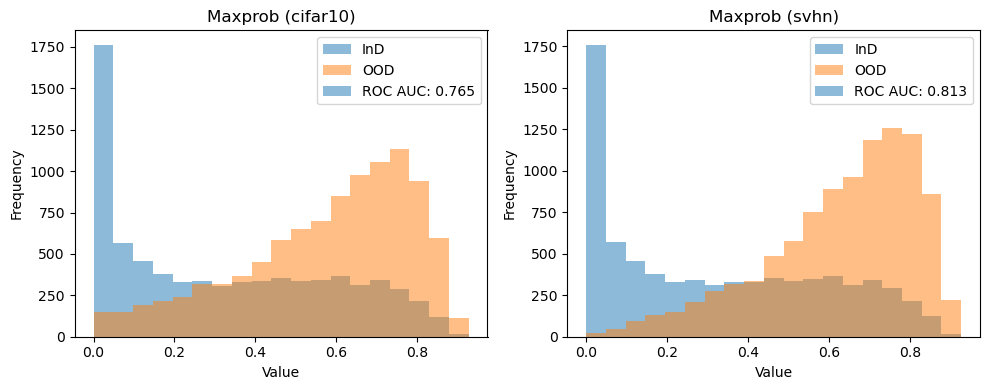

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_maxprob_ensemble = plot_histogram_eq_width(axs[0], data1=cifar100_maxprob_ensemble, data2=cifar10_maxprob_ensemble, title="Maxprob (cifar10)")
roc_auc_svhn_maxprob_ensemble = plot_histogram_eq_width(axs[1], data1=cifar100_maxprob_ensemble, data2=svhn_maxprob_ensemble, title="Maxprob (svhn)")

plt.tight_layout()
plt.show()

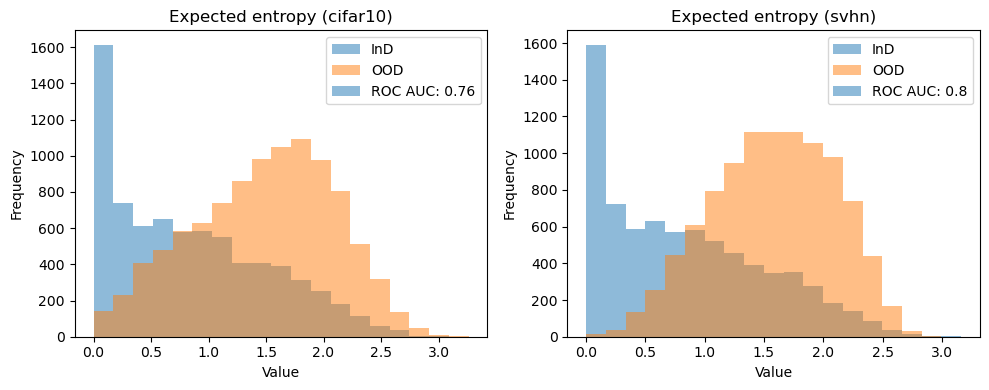

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_EH_ensemble = plot_histogram_eq_width(axs[0], data1=cifar100_EH_ensemble, data2=cifar10_EH_ensemble, title="Expected entropy (cifar10)")
roc_auc_svhn_EH_ensemble = plot_histogram_eq_width(axs[1], data1=cifar100_EH_ensemble, data2=svhn_EH_ensemble, title="Expected entropy (svhn)")

plt.tight_layout()
plt.show()

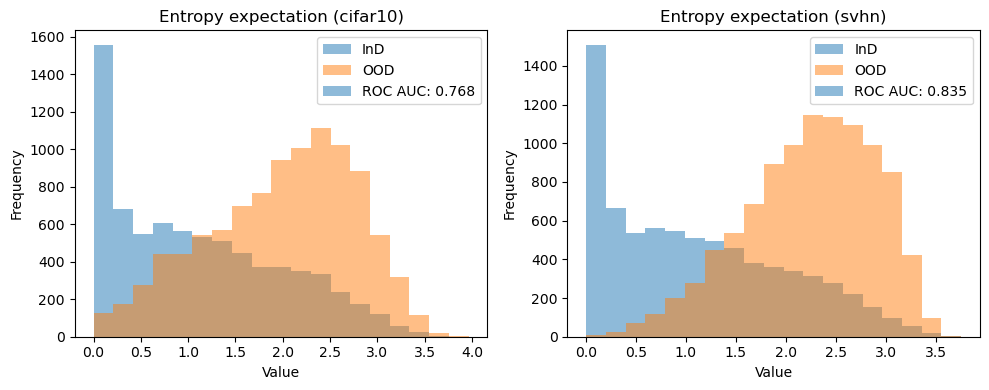

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_HE_ensemble = plot_histogram_eq_width(axs[0], data1=cifar100_HE_ensemble, data2=cifar10_HE_ensemble, title="Entropy expectation (cifar10)")
roc_auc_svhn_HE_ensemble = plot_histogram_eq_width(axs[1], data1=cifar100_HE_ensemble, data2=svhn_HE_ensemble, title="Entropy expectation (svhn)")

plt.tight_layout()
plt.show()

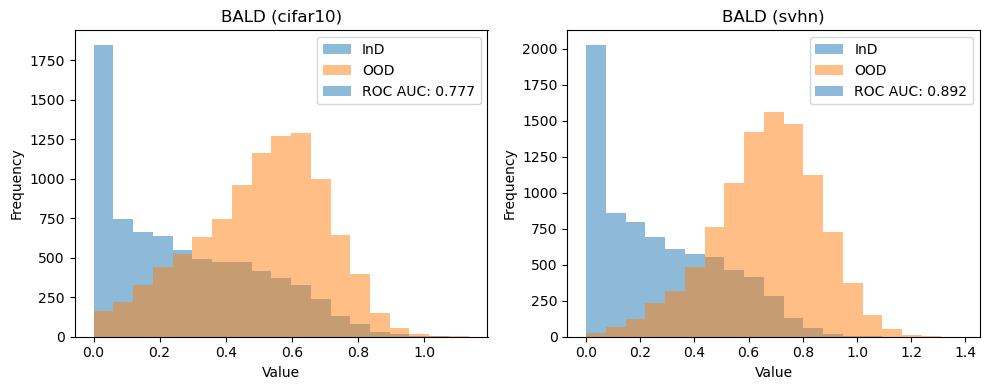

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_BALD_ensemble = plot_histogram_eq_width(axs[0],
                                                      data1=np.array(cifar100_HE_ensemble) - np.array(cifar100_EH_ensemble),
                                                      data2=np.array(cifar10_HE_ensemble) - np.array(cifar10_EH_ensemble),
                                                      title="BALD (cifar10)")

roc_auc_svhn_BALD_ensemble = plot_histogram_eq_width(axs[1],
                                                   data1=np.array(cifar100_HE_ensemble) - np.array(cifar100_EH_ensemble),
                                                   data2=np.array(svhn_HE_ensemble) - np.array(svhn_EH_ensemble),
                                                   title="BALD (svhn)")

plt.tight_layout()
plt.show()

As expected, measures of uncertainty associated with epistemic and total uncertainties cope with the task of searching for out-of-distribution data much better than measures for aleatoric uncertainty.

This shows the importance of separating the types of uncertainty for different methods.

### Let's look at the top of the most uncertain predictions

#### BALD

In [58]:
dataset_idxs, within_dataset_idxs = get_extreme_score_indices(
    scores0=np.array(cifar100_HE_ensemble) - np.array(cifar100_EH_ensemble),
    scores1=np.array(svhn_HE_ensemble) - np.array(svhn_EH_ensemble),
    k=10, extreme='max'
)

In [59]:
# Which share of OOD objects appeared in top k the most uncertain?
np.mean(dataset_idxs)

1.0

<Figure size 0x300 with 0 Axes>

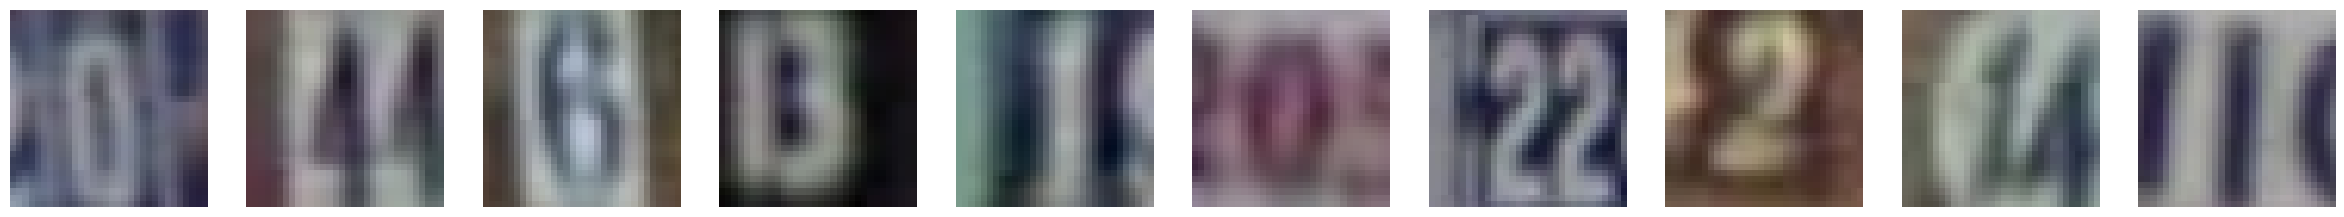

In [60]:
plot_images(dataset=cifar100_valid, indices=within_dataset_idxs[dataset_idxs==0])
plot_images(dataset=svhn_valid, indices=within_dataset_idxs[dataset_idxs==1])

#### Expected entropy (aleatoric uncertainty)

In [61]:
dataset_idxs, within_dataset_idxs = get_extreme_score_indices(
    scores0=np.array(cifar100_EH_ensemble),
    scores1=np.array(svhn_EH_ensemble),
    k=10, extreme='max'
)

In [62]:
# Which share of OOD objects appeared in top k the most uncertain?
np.mean(dataset_idxs)

0.3

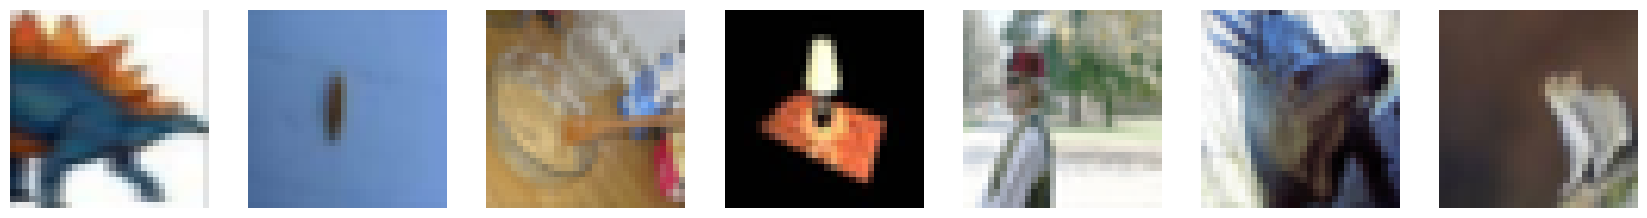

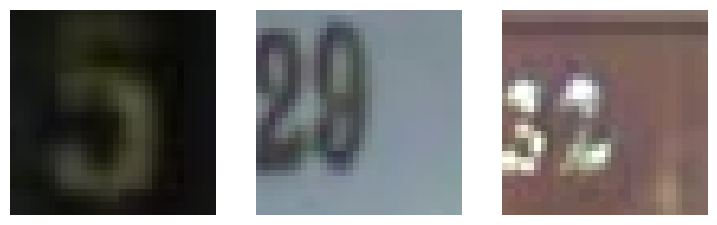

In [63]:
plot_images(dataset=cifar100_valid, indices=within_dataset_idxs[dataset_idxs==0])
plot_images(dataset=svhn_valid, indices=within_dataset_idxs[dataset_idxs==1])

In [64]:
RESULTS.append({
    "method": "ensemble",
    "ood": "cifar10",
    "HE": roc_auc_cifar10_HE_ensemble,
    "EH": roc_auc_cifar10_EH_ensemble,
    "BALD": roc_auc_cifar10_BALD_ensemble,
    "maxprob": roc_auc_cifar10_maxprob_ensemble
})

In [65]:
RESULTS.append({
    "method": "ensemble",
    "ood": "svhn",
    "HE": roc_auc_svhn_HE_ensemble,
    "EH": roc_auc_svhn_EH_ensemble,
    "BALD": roc_auc_svhn_BALD_ensemble,
    "maxprob": roc_auc_svhn_maxprob_ensemble
})

## Let's calibrate each model in the ensemble!

We saw that the calibration of one model reduces the ECE, and also lead to an improvement in OOD detection.

The idea -- and let's calibrate each model in the ensemble. Maybe then the ECE will decrease, and OOD detection will become even better?

What do you think will happen to ECE?

The intuition is this - we calibrate each model and effectively reduce it to one unit of measurement (real probabilities). Accordingly, the ensemble as a whole will be calibrated better...

In [66]:
calibrated_ensemble = ensemble_calibration(ensemble=ensemble, calloader=cifar100_calloader, device=device)

Before temperature - NLL: 1.199, ECE: 0.068
Optimal temperature: 1.265
After temperature - NLL: 1.162, ECE: 0.026
Before temperature - NLL: 1.186, ECE: 0.077
Optimal temperature: 1.268
After temperature - NLL: 1.148, ECE: 0.022
Before temperature - NLL: 1.208, ECE: 0.076
Optimal temperature: 1.306
After temperature - NLL: 1.158, ECE: 0.024
Before temperature - NLL: 1.228, ECE: 0.084
Optimal temperature: 1.290
After temperature - NLL: 1.182, ECE: 0.022
Before temperature - NLL: 1.207, ECE: 0.073
Optimal temperature: 1.309
After temperature - NLL: 1.156, ECE: 0.024
Before temperature - NLL: 1.178, ECE: 0.068
Optimal temperature: 1.249
After temperature - NLL: 1.146, ECE: 0.025
Before temperature - NLL: 1.158, ECE: 0.060
Optimal temperature: 1.249
After temperature - NLL: 1.126, ECE: 0.015
Before temperature - NLL: 1.189, ECE: 0.066
Optimal temperature: 1.280
After temperature - NLL: 1.147, ECE: 0.021
Before temperature - NLL: 1.174, ECE: 0.062
Optimal temperature: 1.264
After temperature

In [67]:
labels, calibrated_ensemble_probs = collect_labels_and_probs_ensemble(ensemble_=calibrated_ensemble, dataloader=cifar100_valloader, device=device)

**Question:** Will the accuracy of the ensemble change after calibration of each of its members?


In the case of one model, nothing has changed. And here?

In [68]:
accuracy_score(y_true=labels, y_pred=np.argmax(calibrated_ensemble_probs, axis=-1))

0.7578666666666667

/Users/maxim.panov/Work/courses/uncertainty_quantification_industrial/labs/lab1/./helpers/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


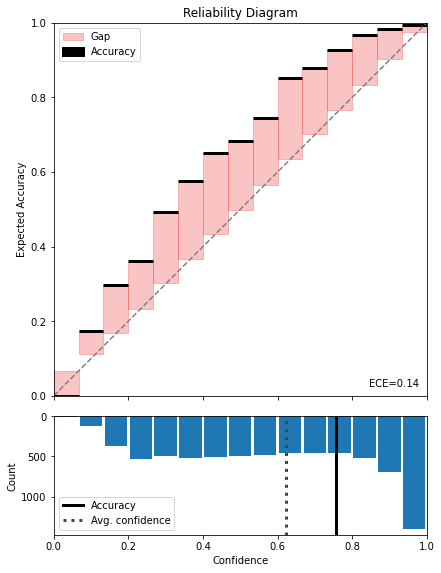

In [69]:
reliability_diagram(
    true_labels=labels,
    pred_labels=np.argmax(calibrated_ensemble_probs, axis=-1),
    confidences=calibrated_ensemble_probs[
        np.arange(len(calibrated_ensemble_probs)),
        np.argmax(calibrated_ensemble_probs, axis=-1)
                      ],
     num_bins=15
    )

It turns out that the calibration of each member of the ensemble ** does not lead to the fact ** that the ensemble itself will be calibrated.

On the contrary, the ensemble becomes underconfident -- that is, it assigns probabilities lower than the expected accuracy.


This effect is known, and is described for example here:
https://arxiv.org/pdf/2101.05397.pdf

Let's calculate the measures of uncertainty...

In [70]:
# Compute scores for CIFAR100
cifar100_EH_cal_ensemble, cifar100_HE_cal_ensemble, cifar100_maxprob_cal_ensemble = compute_scores_ensemble(calibrated_ensemble, cifar100_valloader, device)

# Compute scores for OOD
cifar10_EH_cal_ensemble, cifar10_HE_cal_ensemble, cifar10_maxprob_cal_ensemble = compute_scores_ensemble(calibrated_ensemble, cifar10_valloader, device)
svhn_EH_cal_ensemble, svhn_HE_cal_ensemble, svhn_maxprob_cal_ensemble = compute_scores_ensemble(calibrated_ensemble, svhn_valloader, device)

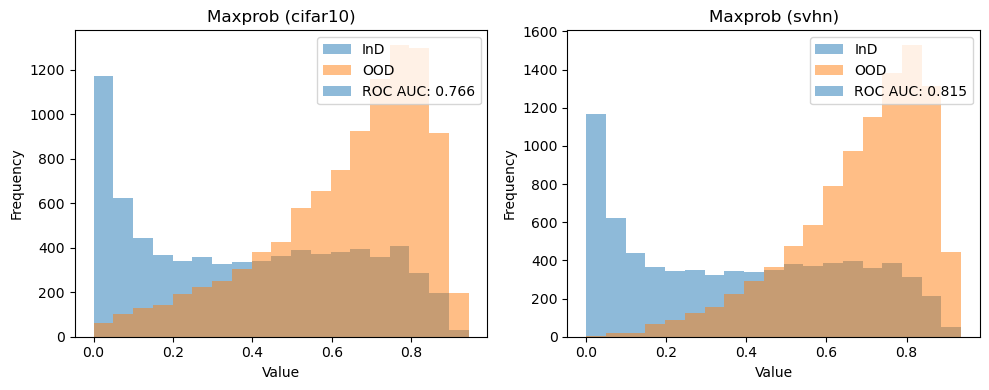

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_maxprob_ensemble_cal = plot_histogram_eq_width(axs[0], data1=cifar100_maxprob_cal_ensemble, data2=cifar10_maxprob_cal_ensemble, title="Maxprob (cifar10)")
roc_auc_svhn_maxprob_ensemble_cal = plot_histogram_eq_width(axs[1], data1=cifar100_maxprob_cal_ensemble, data2=svhn_maxprob_cal_ensemble, title="Maxprob (svhn)")

plt.tight_layout()
plt.show()

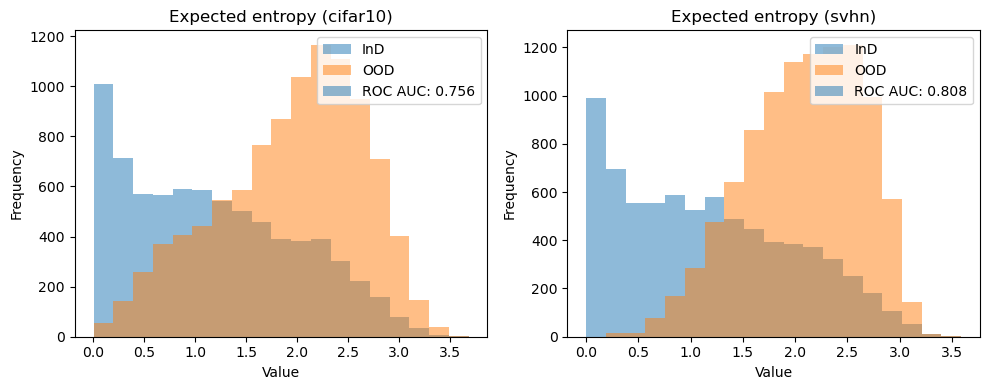

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_EH_ensemble_cal = plot_histogram_eq_width(axs[0], data1=cifar100_EH_cal_ensemble, data2=cifar10_EH_cal_ensemble, title="Expected entropy (cifar10)")
roc_auc_svhn_EH_ensemble_cal = plot_histogram_eq_width(axs[1], data1=cifar100_EH_cal_ensemble, data2=svhn_EH_cal_ensemble, title="Expected entropy (svhn)")

plt.tight_layout()
plt.show()

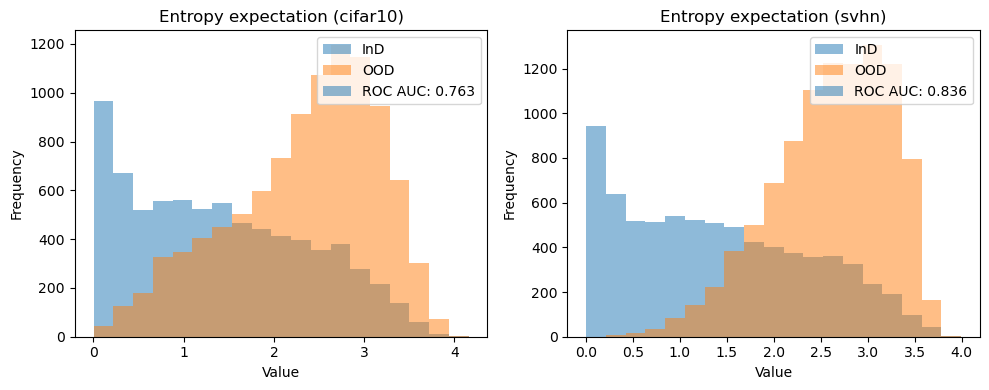

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_HE_ensemble_cal = plot_histogram_eq_width(axs[0], data1=cifar100_HE_cal_ensemble, data2=cifar10_HE_cal_ensemble, title="Entropy expectation (cifar10)")
roc_auc_svhn_HE_ensemble_cal = plot_histogram_eq_width(axs[1], data1=cifar100_HE_cal_ensemble, data2=svhn_HE_cal_ensemble, title="Entropy expectation (svhn)")

plt.tight_layout()
plt.show()

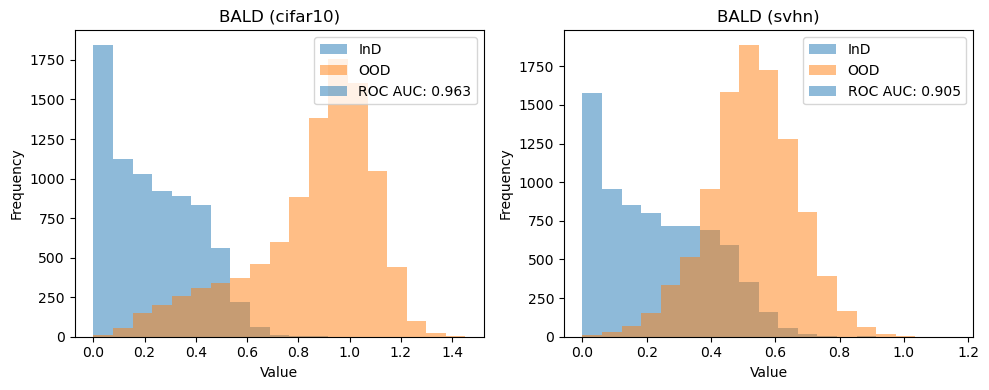

In [74]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_BALD_ensemble_cal = plot_histogram_eq_width(axs[0],
                                                      data1=np.array(cifar100_HE_cal_ensemble) - np.array(cifar100_EH_cal_ensemble),
                                                      data2=np.array(cifar10_HE_cal_ensemble) - np.array(cifar10_EH_ensemble),
                                                      title="BALD (cifar10)")

roc_auc_svhn_BALD_ensemble_cal = plot_histogram_eq_width(axs[1],
                                                   data1=np.array(cifar100_HE_cal_ensemble) - np.array(cifar100_EH_cal_ensemble),
                                                   data2=np.array(svhn_HE_cal_ensemble) - np.array(svhn_EH_cal_ensemble),
                                                   title="BALD (svhn)")

plt.tight_layout()
plt.show()

We see that the calibration significantly improved OOD detection. On CIFAR10 for BALD, the result turned out unexpectedly good!

### Top of the most uncertain

#### BALD

In [75]:
dataset_idxs, within_dataset_idxs = get_extreme_score_indices(
    scores0=np.array(cifar100_HE_cal_ensemble) - np.array(cifar100_EH_cal_ensemble),
    scores1=np.array(svhn_HE_cal_ensemble) - np.array(svhn_EH_cal_ensemble),
    k=10, extreme='max'
)

In [76]:
# Which share of OOD objects appeared in top k the most uncertain?
np.mean(dataset_idxs)

1.0

<Figure size 0x300 with 0 Axes>

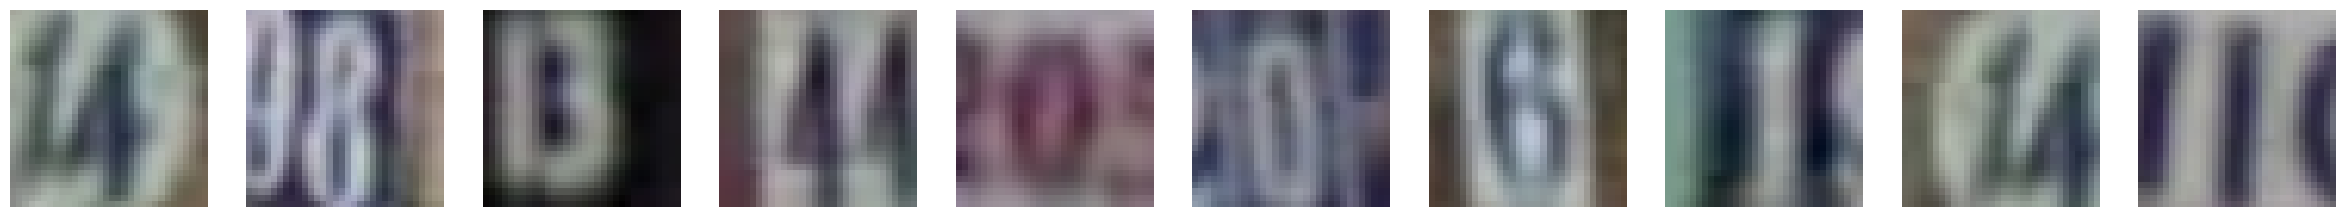

In [77]:
plot_images(dataset=cifar100_valid, indices=within_dataset_idxs[dataset_idxs==0])
plot_images(dataset=svhn_valid, indices=within_dataset_idxs[dataset_idxs==1])

In [78]:
RESULTS.append({
    "method": "ensemble cal",
    "ood": "cifar10",
    "HE": roc_auc_cifar10_HE_ensemble_cal,
    "EH": roc_auc_cifar10_EH_ensemble_cal,
    "BALD": roc_auc_cifar10_BALD_ensemble_cal,
    "maxprob": roc_auc_cifar10_maxprob_ensemble_cal
})

In [79]:
RESULTS.append({
    "method": "ensemble cal",
    "ood": "svhn",
    "HE": roc_auc_svhn_HE_ensemble_cal,
    "EH": roc_auc_svhn_EH_ensemble_cal,
    "BALD": roc_auc_svhn_BALD_ensemble_cal,
    "maxprob": roc_auc_svhn_maxprob_ensemble_cal
})

# Monte-Carlo Dropout

http://proceedings.mlr.press/v48/gal16.pdf

Gal, Yarin, and Zoubin Ghahramani. "Dropout as a bayesian approximation: Representing model uncertainty in deep learning." international conference on machine learning. PMLR, 2016.

As we discussed at the lecture, Dropout in neural networks can be considered as a special variational family. It turns out that training a neural network with a dropout when adding a special l2 regularization is equivalent to variational inference.

The variational family in the case of a dropout looks like this:

$$
\Theta_i = M_i \text{diag}(z_{i, j})_{j=1}^K,
$$
$$
z_{i, j} = \text{Bernoulli}(p_i),
$$
where $p_i$ is the dropout parameter.

Let's see how good this model is in terms of accuracy and prediction of OOD.

In [82]:
model_drop_conf = PreResNet20Drop()
model_drop = model_drop_conf.base(*model_drop_conf.args, num_classes=100, **model_drop_conf.kwargs)
model_drop.load_state_dict(torch.load(f'./helpers/preresnetdrop20-0.pth', map_location=device))
model_drop = model_drop.to(device)

def enable_dropout(model):
    """Function to enable the dropout layers during model evaluation"""
    for module in model.modules():
        if module.__class__.__name__.startswith('Dropout'):
            module.train()
#
model.eval()
enable_dropout(model_drop)
#
print("OK!")

OK!


In [83]:
N_MC_DROP_SAMPLES = 20

In [84]:
labels, probs_mcdropout = collect_labels_and_probs_mcdropout(mc_model=model_drop,
                                                             dataloader=cifar100_valloader,
                                                             n_samples=N_MC_DROP_SAMPLES, device=device)

/Users/maxim.panov/Work/courses/uncertainty_quantification_industrial/labs/lab1/./helpers/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


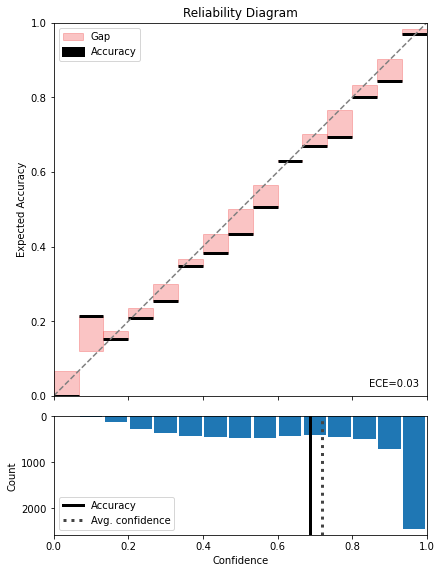

In [85]:
reliability_diagram(
    true_labels=labels,
    pred_labels=np.argmax(probs_mcdropout, axis=-1),
    confidences=probs_mcdropout[
        np.arange(len(probs_mcdropout)),
        np.argmax(probs_mcdropout, axis=-1)
                      ],
     num_bins=15
    )

In [86]:
# Compute scores for CIFAR100
cifar100_EH_mcdrop, cifar100_HE_mcdrop, cifar100_maxprob_mcdrop = compute_scores_mcdropout(
    model_drop, cifar100_valloader, N_MC_DROP_SAMPLES, device)

# Compute scores for OOD
cifar10_EH_mcdrop, cifar10_HE_mcdrop, cifar10_maxprob_mcdrop = compute_scores_mcdropout(
    model_drop, cifar10_valloader, N_MC_DROP_SAMPLES, device)

svhn_EH_mcdrop, svhn_HE_mcdrop, svhn_maxprob_mcdrop = compute_scores_mcdropout(
    model_drop, svhn_valloader, N_MC_DROP_SAMPLES, device)

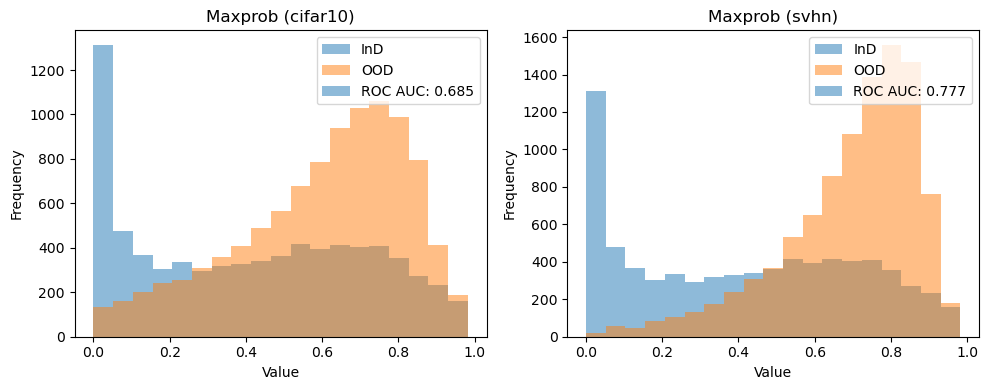

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_maxprob_mcdropout = plot_histogram_eq_width(axs[0], data1=cifar100_maxprob_mcdrop, data2=cifar10_maxprob_mcdrop, title="Maxprob (cifar10)")
roc_auc_svhn_maxprob_mcdropout = plot_histogram_eq_width(axs[1], data1=cifar100_maxprob_mcdrop, data2=svhn_maxprob_mcdrop, title="Maxprob (svhn)")

plt.tight_layout()
plt.show()

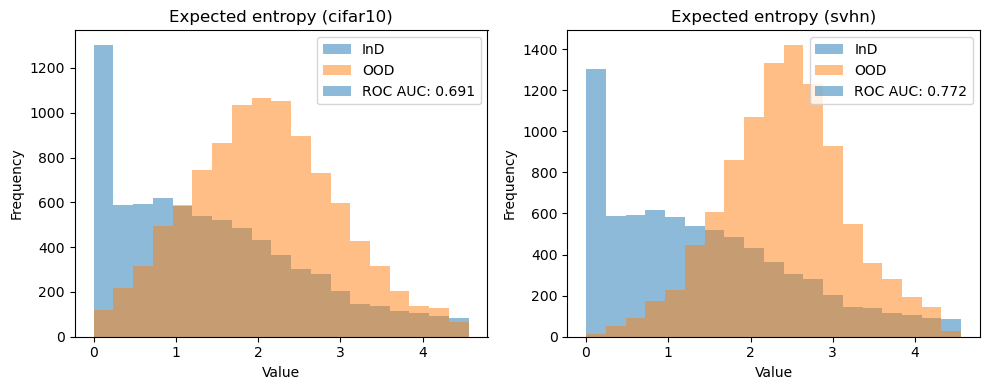

In [88]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_EH_mcdropout = plot_histogram_eq_width(axs[0], data1=cifar100_EH_mcdrop, data2=cifar10_EH_mcdrop, title="Expected entropy (cifar10)")
roc_auc_svhn_EH_mcdropout = plot_histogram_eq_width(axs[1], data1=cifar100_EH_mcdrop, data2=svhn_EH_mcdrop, title="Expected entropy (svhn)")

plt.tight_layout()
plt.show()

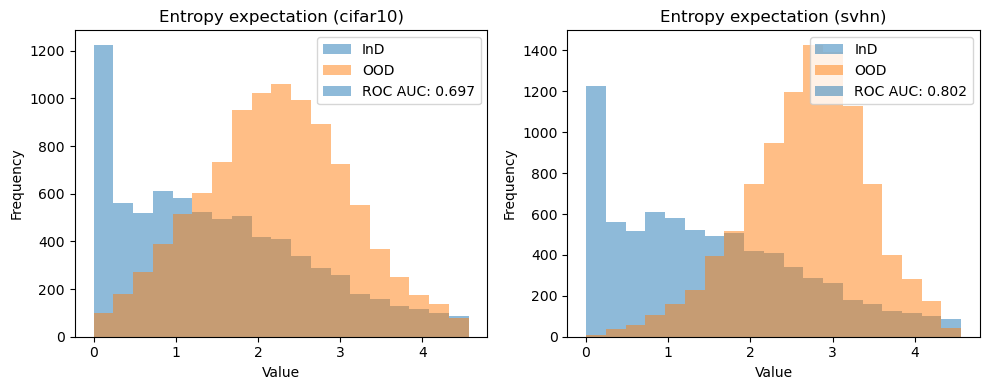

In [89]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_HE_mcdropout = plot_histogram_eq_width(axs[0], data1=cifar100_HE_mcdrop, data2=cifar10_HE_mcdrop, title="Entropy expectation (cifar10)")
roc_auc_svhn_HE_mcdropout = plot_histogram_eq_width(axs[1], data1=cifar100_HE_mcdrop, data2=svhn_HE_mcdrop, title="Entropy expectation (svhn)")

plt.tight_layout()
plt.show()

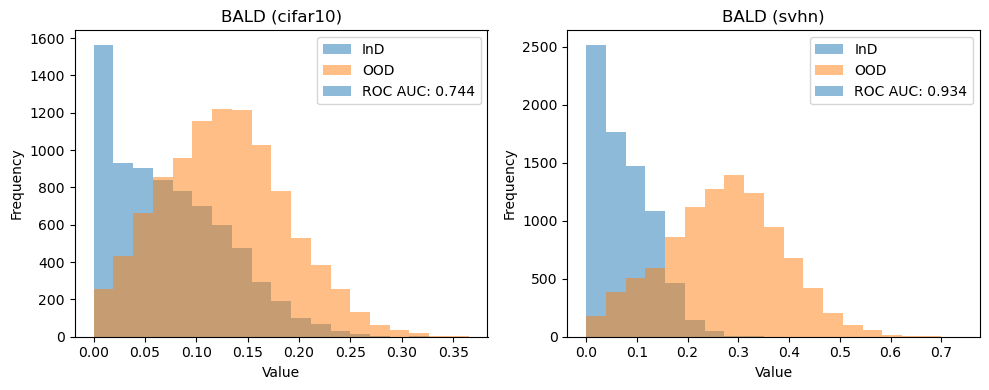

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_BALD_mcdropout = plot_histogram_eq_width(axs[0],
                                                      data1=np.array(cifar100_HE_mcdrop) - np.array(cifar100_EH_mcdrop),
                                                      data2=np.array(cifar10_HE_mcdrop) - np.array(cifar10_EH_mcdrop),
                                                      title="BALD (cifar10)")

roc_auc_svhn_BALD_mcdropout = plot_histogram_eq_width(axs[1],
                                                   data1=np.array(cifar100_HE_mcdrop) - np.array(cifar100_EH_mcdrop),
                                                   data2=np.array(svhn_HE_mcdrop) - np.array(svhn_EH_mcdrop),
                                                   title="BALD (svhn)")

plt.tight_layout()
plt.show()

MC Dropout performed well. One of its advantages is that the method is very simple both in training and in application.

It is enough just to switch the dropout layers to the training mode at the time of prediction, and simply collect the resulting predictions.

### Top of the most uncertain objects

In [91]:
dataset_idxs, within_dataset_idxs = get_extreme_score_indices(
    scores0=np.array(cifar100_HE_mcdrop) - np.array(cifar100_EH_mcdrop),
    scores1=np.array(svhn_HE_mcdrop) - np.array(svhn_EH_mcdrop),
    k=10, extreme='max'
)

In [92]:
# Which share of OOD objects appeared in top k the most uncertain?
np.mean(dataset_idxs)

1.0

<Figure size 0x300 with 0 Axes>

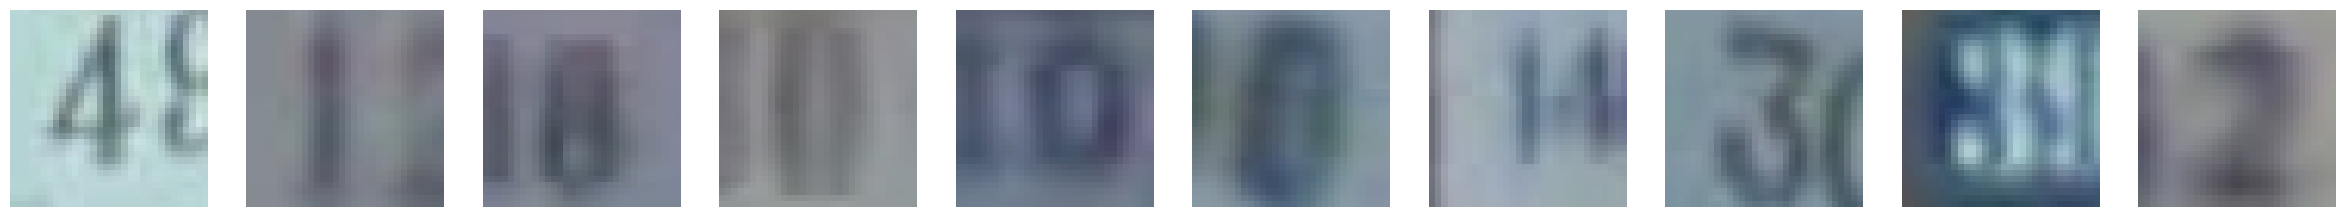

In [93]:
plot_images(dataset=cifar100_valid, indices=within_dataset_idxs[dataset_idxs==0])
plot_images(dataset=svhn_valid, indices=within_dataset_idxs[dataset_idxs==1])

In [94]:
RESULTS.append({
    "method": "mcdropout",
    "ood": "cifar10",
    "HE": roc_auc_cifar10_HE_mcdropout,
    "EH": roc_auc_cifar10_EH_mcdropout,
    "BALD": roc_auc_cifar10_BALD_mcdropout,
    "maxprob": roc_auc_cifar10_maxprob_mcdropout
})

In [95]:
RESULTS.append({
    "method": "mcdropout",
    "ood": "svhn",
    "HE": roc_auc_svhn_HE_mcdropout,
    "EH": roc_auc_svhn_EH_mcdropout,
    "BALD": roc_auc_svhn_BALD_mcdropout,
    "maxprob": roc_auc_svhn_maxprob_mcdropout
})

# DDU

Let's now consider deterministic models that use embeddings.


About these methods in general, it must be said that they depend very much on the geometry of embeddings.

At the lecture, we discussed the essential problem of `feature collapse", when the mappings of different objects turn out to be the same.

The literature suggests several ways to combat this effect. They all boil down to ensuring that the model satisfies the bi-Lipschitz condition:

$$
K_1\|x_1 - x_0\| \leq \|f_\theta(x_1) - f_\theta(x_0)\| \leq K_2\|x_1 - x_0\|.
$$

This can be achieved in the following ways:

- use the ResNet architecture, which will satisfy the Lipschitz condition from below
- use one of the techniques to satisfy the Lipschitz condition from above. Such techniques are 1) weight clipping, 2) gradient penalty and 3) spectral normalization.

In our example, we will use spectral normalization.


It should also be recalled that these methods, unlike MC Dropout, do not require any changes at all either in the architecture of the model or in the learning process. In fact, these methods can also be used in situations where the bi-Lipschitz condition is not met, but the result will be somewhat worse.

In [99]:
from aux import get_embeddings, compute_log_densities, compute_classwise_mean_cov

In [100]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_conf = PreResNet20Spectral()
model = model_conf.base(*model_conf.args, num_classes=100, **model_conf.kwargs)
model.load_state_dict(torch.load(f'./helpers/preresnetspectral20-1.pth', map_location=device))
model = model.to(device)
model.eval()
print("OK!")

OK!


In [101]:
embeddings, labels = get_embeddings(model=model, dataloader=cifar100_trainloader, device=device)

In [102]:
means, covs = compute_classwise_mean_cov(embeddings, labels)

In [103]:
log_densities_cifar100 = compute_log_densities(model, cifar100_valloader, means, covs, device).cpu().numpy()

log_densities_cifar10 = compute_log_densities(model, cifar10_valloader, means, covs, device).cpu().numpy()
log_densities_svhn = compute_log_densities(model, svhn_valloader, means, covs, device).cpu().numpy()

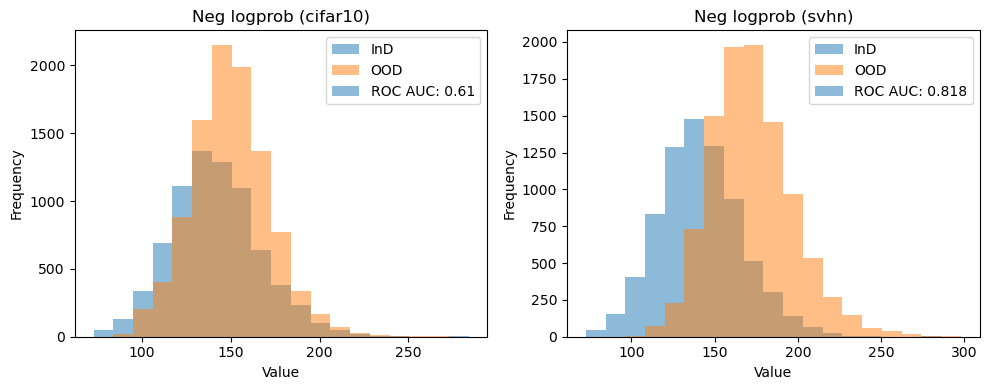

In [104]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

roc_auc_cifar10_ddu = plot_histogram_eq_width(axs[0], data1=-log_densities_cifar100, data2=-log_densities_cifar10, title="Neg logprob (cifar10)")
roc_auc_svhn_ddu = plot_histogram_eq_width(axs[1], data1=-log_densities_cifar100, data2=-log_densities_svhn, title="Neg logprob (svhn)")

plt.tight_layout()
plt.show()

### Top of the most uncertain objects

In [105]:
dataset_idxs, within_dataset_idxs = get_extreme_score_indices(
    scores0=-log_densities_cifar100,
    scores1=-log_densities_svhn,
    k=10, extreme='max'
)

In [106]:
# Which share of OOD objects appeared in top k the most uncertain?
np.mean(dataset_idxs)

0.9

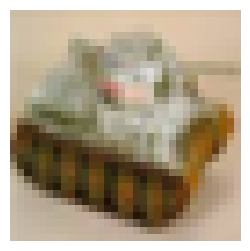

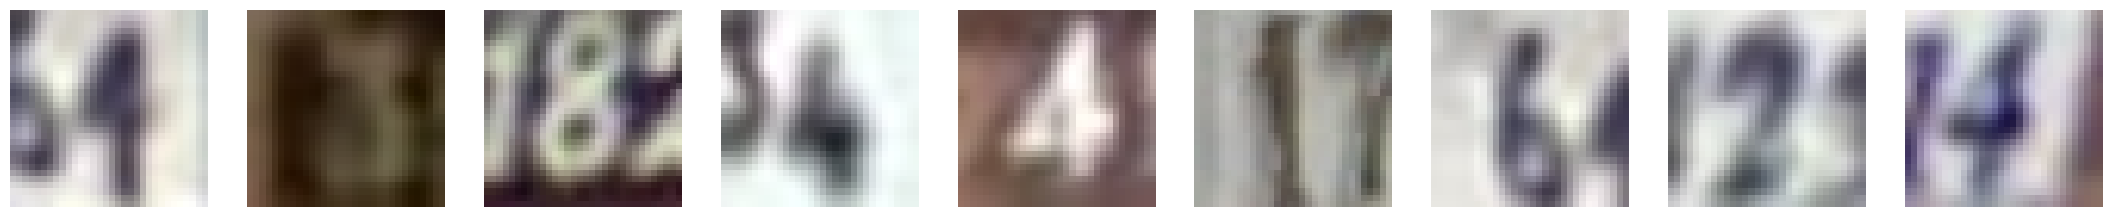

In [107]:
plot_images(dataset=cifar100_valid, indices=within_dataset_idxs[dataset_idxs==0])
plot_images(dataset=svhn_valid, indices=within_dataset_idxs[dataset_idxs==1])

In [108]:
RESULTS.append({
    "method": "ddu",
    "ood": "cifar10",
    "metric": roc_auc_cifar10_ddu
})

In [109]:
RESULTS.append({
    "method": "ddu",
    "ood": "svhn",
    "metric": roc_auc_svhn_ddu
})

As you can see, these methods did not work so well on the considered datasets.

However, it is worth remembering that these are post-processing methods that can be applied to any pre-trained model without any modifications. All that is required is the use of a training dataset.

# Now let's summarize

In [110]:
df = pd.DataFrame(RESULTS)

In [111]:
df

,method,ood,entropy,maxprob,HE,EH,BALD,metric
0,single model,cifar10,0.731,0.718,NaN,NaN,NaN,NaN
1,single model,svhn,0.742,0.715,NaN,NaN,NaN,NaN
2,single model cal,cifar10,0.732,0.725,NaN,NaN,NaN,NaN
3,single model cal,svhn,0.761,0.731,NaN,NaN,NaN,NaN
4,ensemble,cifar10,NaN,0.765,0.768,0.760,0.777,NaN
5,ensemble,svhn,NaN,0.813,0.835,0.800,0.892,NaN
6,ensemble cal,cifar10,NaN,0.766,0.763,0.756,0.963,NaN
7,ensemble cal,svhn,NaN,0.815,0.836,0.808,0.905,NaN
8,mcdropout,cifar10,NaN,0.685,0.697,0.691,0.744,NaN
9,mcdropout,svhn,NaN,0.777,0.802,0.772,0.934,NaN


In [112]:
df['max_value'] = df[['entropy', 'maxprob', 'HE', 'EH', 'BALD', 'metric']].max(axis=1)

In [113]:
final_df = df[['method', 'ood', 'max_value']]

In [114]:
final_df[final_df.ood == 'svhn'].sort_values(by='max_value', ascending=False)

,method,ood,max_value
9,mcdropout,svhn,0.934
7,ensemble cal,svhn,0.905
5,ensemble,svhn,0.892
11,ddu,svhn,0.818
3,single model cal,svhn,0.761
1,single model,svhn,0.742


In [115]:
final_df[final_df.ood == 'cifar10'].sort_values(by='max_value', ascending=False)

,method,ood,max_value
6,ensemble cal,cifar10,0.963
4,ensemble,cifar10,0.777
8,mcdropout,cifar10,0.744
2,single model cal,cifar10,0.732
0,single model,cifar10,0.731
10,ddu,cifar10,0.610


### Conclusions

As you can see, ensembles consistently show the strongest result. This is not surprising, but it should be remembered that ensemble training, just like prediction, is very computationally expensive. For this reason, people have come up with many other, lightweight approaches that allow us to obtain uncertainty estimates with less computational costs.

Methods like MC Dropout show good results, but require changes during training, or are expensive in terms of output (as in the case of SWAG when using batch normalization).

Methods like DDU are very simple, fast and easy to use, however, they strongly depend on the geometry of the features (in the case of cifar100 vs cifar10, the geometry is not very good), but they can be a good starting point in the problem under consideration.